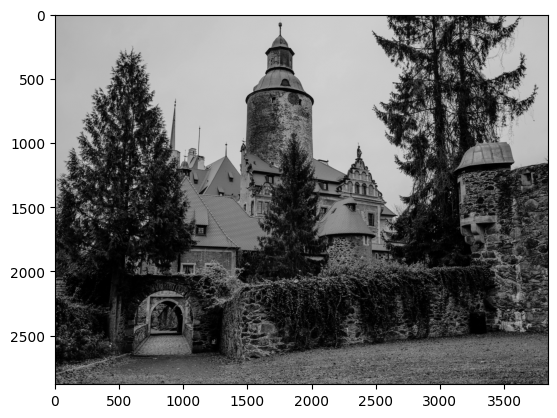

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import time
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Load an image from file
imagenEntrada = cv2.imread('pexels_borde.jpg')

# Convert the image to grayscale
imagen = cv2.cvtColor(imagenEntrada, cv2.COLOR_BGR2GRAY)

# Show the Gray Image
plt.imshow(imagen, cmap='gray')

Kernel generado con exito
Tiempo de ejecucion - Secuencial: 70.09054500000002 segundos
Procesando: 2880x3840
Padded: 2882x3842
✓ Kernel compilado exitosamente
Grid: 240x180, Block: 16x16
✓ Kernel ejecutado exitosamente
Tiempo GPU: 0.076850 s


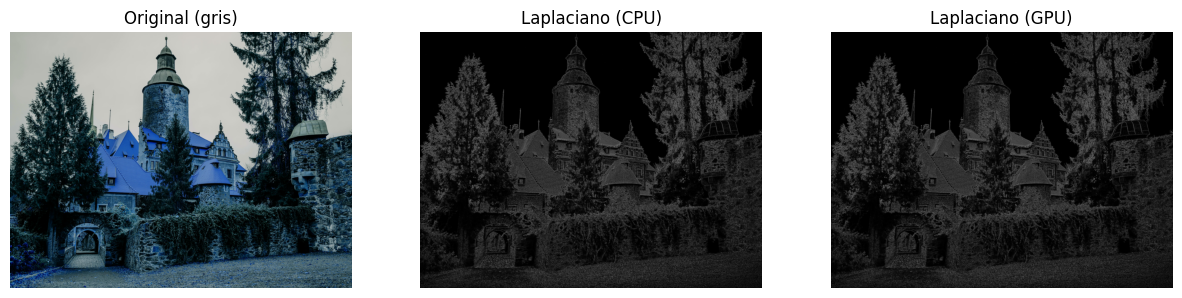

In [5]:
# Generacion del Kernel
def generar_Kernel(numero: int):
    if numero % 2 == 0:
        raise ValueError("El numero debe ser impar")
    else:
        kernel = np.ones((numero, numero), np.float32)
        kernel[numero //2, numero //2] = -1 * (numero * numero - 1)
        return kernel

kernel = generar_Kernel(3)
print("Kernel generado con exito")

# Funcion para el filtro secuencial

def filtro_laplace_secuencial(imagen: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    matrizImagen = imagen.astype(np.float32)

    k = kernel.shape[0]
    pad = k // 2
    h, w = matrizImagen.shape

    imagenPadded = np.pad(matrizImagen, pad, mode='constant', constant_values=0)

    salida = np.zeros_like(matrizImagen, dtype=np.float32)

    for i in range(h):
        for j in range(w):
            region = imagenPadded[i:i + k, j:j + k]
            salida[i, j] = np.sum(region * kernel)
            
    salida = np.clip(salida, 0, 255).astype(np.uint8)
    return salida

# Codigo de ejecucion con Pycuda (GPU)
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
import numpy as np
import time

def filtro_laplace_paralelo(imagen: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    matrizImagen = imagen.astype(np.float32)
    k = kernel.shape[0]
    pad = k // 2
    alto, ancho = matrizImagen.shape
    
    print(f"Procesando: {alto}x{ancho}")

    # Padding con zeros
    imagenPadded = np.pad(matrizImagen, ((pad, pad), (pad, pad)), 
                          mode='constant', constant_values=0.0)
    
    # Asegurar que todo esté contiguo y en float32
    imagenPadded = np.ascontiguousarray(imagenPadded, dtype=np.float32)
    salida = np.zeros((alto, ancho), dtype=np.float32, order='C')
    kernel_flat = np.ascontiguousarray(kernel.flatten(), dtype=np.float32)
    
    altoPadded, anchoPadded = imagenPadded.shape
    print(f"Padded: {altoPadded}x{anchoPadded}")

    # Kernel CUDA simplificado al máximo
    kernel_code = """
    __global__ void filtro_laplace(float *imagen, float *kernel, float *salida,
                                   int ancho, int alto, int k, int anchoPadded) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;

        if (x >= ancho || y >= alto) return;

        float suma = 0.0f;
        
        #pragma unroll
        for (int ky = 0; ky < 3; ky++) {
            #pragma unroll
            for (int kx = 0; kx < 3; kx++) {
                int posY = y + ky;
                int posX = x + kx;
                int idxImg = posY * anchoPadded + posX;
                int idxKer = ky * 3 + kx;
                suma += imagen[idxImg] * kernel[idxKer];
            }
        }
        
        salida[y * ancho + x] = suma;
    }
    """

    # Compilar con opciones específicas para evitar el error
    try:
        mod = SourceModule(kernel_code, 
                          options=['--use_fast_math'],
                          no_extern_c=False)
        print("✓ Kernel compilado exitosamente")
    except Exception as e:
        print(f"✗ Error de compilación: {e}")
        # Intentar sin optimizaciones
        try:
            mod = SourceModule(kernel_code, no_extern_c=True)
            print("✓ Kernel compilado (sin optimizaciones)")
        except Exception as e2:
            print(f"✗ Error crítico: {e2}")
            raise

    laplace_kernel = mod.get_function("filtro_laplace")
    
    # Configuración conservadora de bloques
    BLOCK_SIZE = 16
    grid_x = (ancho + BLOCK_SIZE - 1) // BLOCK_SIZE
    grid_y = (alto + BLOCK_SIZE - 1) // BLOCK_SIZE
    
    print(f"Grid: {grid_x}x{grid_y}, Block: {BLOCK_SIZE}x{BLOCK_SIZE}")

    tiempoInicial = time.perf_counter()

    try:
        # Asignar memoria GPU explícitamente
        imagen_gpu = drv.mem_alloc(imagenPadded.nbytes)
        kernel_gpu = drv.mem_alloc(kernel_flat.nbytes)
        salida_gpu = drv.mem_alloc(salida.nbytes)
        
        # Copiar a GPU
        drv.memcpy_htod(imagen_gpu, imagenPadded)
        drv.memcpy_htod(kernel_gpu, kernel_flat)
        
        # Ejecutar kernel
        laplace_kernel(
            imagen_gpu,
            kernel_gpu,
            salida_gpu,
            np.int32(ancho),
            np.int32(alto),
            np.int32(k),
            np.int32(anchoPadded),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(grid_x, grid_y)
        )
        
        # Copiar resultado de vuelta
        drv.memcpy_dtoh(salida, salida_gpu)
        
        # Liberar memoria
        imagen_gpu.free()
        kernel_gpu.free()
        salida_gpu.free()
        
        print("✓ Kernel ejecutado exitosamente")
        
    except Exception as e:
        print(f"✗ Error de ejecución: {e}")
        raise

    tiempoFinal = time.perf_counter()
    print(f"Tiempo GPU: {tiempoFinal - tiempoInicial:.6f} s")

    salida = np.clip(salida, 0, 255).astype(np.uint8)
    return salida

tiempoInicial  = time.perf_counter()
resultado = filtro_laplace_secuencial(imagen, kernel)
tiempoFinal = time.perf_counter()
print(f"Tiempo de ejecucion - Secuencial: {tiempoFinal - tiempoInicial} segundos")
resultadoParalelo = filtro_laplace_paralelo(imagen, kernel)

# Mostrar resultados
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original (gris)")
plt.imshow(imagenEntrada, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Laplaciano (CPU)")
plt.imshow(resultado, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Laplaciano (GPU)")
plt.imshow(resultadoParalelo, cmap='gray')
plt.axis('off')

plt.show()
